In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from typing import List
import pickle

In [4]:
with open("data/bert_tokenized/bert_train_data.pkl", "rb") as f:
    train_dev = pickle.load(f)

with open("data/bert_tokenized/bert_test_data.pkl","rb") as f:
    test = pickle.load(f)

In [2]:
# # load data, split
# train_dev = pd.read_csv("data/downloaded/twitter-train-clean.tsv", names=["label","text"],encoding="utf-8",sep='\t').dropna()
# # train, dev = train_test_split(train_dev, test_size=0.2)
# test = pd.read_csv("data/downloaded/twitter-test-clean.tsv", names=["label","text"],encoding="utf-8",sep='\t').dropna()

In [5]:
def map_label(label):
    if label == "negative":
        return 0
    elif label =="neutral":
        return 1
    elif label =="positive":
        return 2

X_train_dev = train_dev.text.to_list()
y_train_dev = train_dev.label.apply(lambda x: map_label(x)).to_list()
# X_dev = dev.text.to_list()
# y_dev = dev.label.apply(lambda x: map_label(x)).to_list()
X_test = test.text.to_list()
y_test = test.label.apply(lambda x: map_label(x)).to_list()

In [6]:
# tf idf tokenization
# tokenizing
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(binary=True)
X_train_tfidf = tf_idf.fit_transform(X_train_dev)
# X_dev_tfidf = tf_idf.fit_tra?nsform(X_dev)

In [7]:
X_train_tfidf.shape

(40280, 42046)

In [8]:
from sklearn.linear_model import SGDClassifier
from scipy.sparse import csr_matrix 

In [9]:
def train_model(X: csr_matrix, y: List) -> None:
    X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2)
    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    dev_score= clf.score(X_dev, y_dev)
    print(f'Train score: {round(train_score,2)}, Dev score: {round(dev_score, 2)}')


In [10]:
train_model(X_train_tfidf, y_train_dev)

Train score: 0.73, Dev score: 0.66


In [11]:
# hyperparam tuning

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


# Phase 1: loss, learning rate and initial learning rate

clf = SGDClassifier()

distributions = dict(
    loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    learning_rate=['optimal', 'invscaling', 'adaptive'],
    eta0=uniform(loc=1e-7, scale=1e-2)
)

random_search_cv = RandomizedSearchCV(
    estimator=clf,
    param_distributions=distributions,
    cv=5,
    n_iter=50
)
random_search_cv.fit(X_train_tfidf, y_train_dev)
print(f'Best params: {random_search_cv.best_params_}')
print(f'Best score: {random_search_cv.best_score_}')

/local/s1620444/tmprojectenv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/local/s1620444/tmprojectenv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/local/s1620444/tmprojectenv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/local/s1620444/tmprojectenv/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/loc

Best params: {'eta0': 0.003985059891628318, 'learning_rate': 'adaptive', 'loss': 'squared_hinge'}
Best score: 0.6379592850049652


In [12]:
sgd_classifier = random_search_cv.best_estimator_

print(sgd_classifier.score(tf_idf.transform(X_test), y_test))

0.5310878192734303


In [13]:
from sklearn.metrics import confusion_matrix

reverse_map = {0: "negative", 1:"neutral",2:"positive"}


confusion_matrix(y_test, sgd_classifier.predict(tf_idf.transform(X_test)))
df_confusion=pd.crosstab(pd.Series([reverse_map[i] for i in y_test], name = "True"), pd.Series([reverse_map[i] for i in sgd_classifier.predict(tf_idf.transform(X_test))], name = "Predicted"), margins=True)

In [14]:
df_confusion

Predicted,negative,neutral,positive,All
True,,,,
negative,438,899,229,1566
neutral,315,2511,599,3425
positive,162,2404,2270,4836
All,915,5814,3098,9827


In [15]:
import pickle
with open('models/baseline.pkl','wb') as f:
    pickle.dump(sgd_classifier,f)

In [17]:
import seaborn as sns

<AxesSubplot:xlabel='Predicted', ylabel='True'>

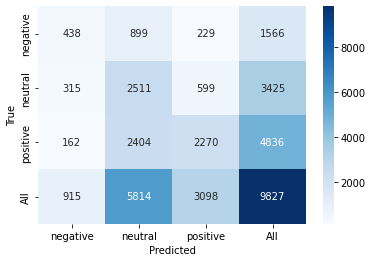

In [18]:
sns.heatmap(df_confusion, annot=True,fmt='g',cmap='Blues')